In [ ]:
# Installation des packages
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn pillow tqdm torch torchvision torchaudio --quiet

# Importation des bibliothèques
import os
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Vérification rapide du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé: {device}")

Device utilisé: cuda


In [ ]:
# 1️⃣ Installer Kaggle
!pip install kaggle --quiet

# 2️⃣ Importer les modules nécessaires
import os
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import files
import shutil

# 3️⃣ Upload kaggle.json depuis ton PC
print("⚠️ Upload ton fichier kaggle.json")
uploaded = files.upload()
kaggle_json_path = next(iter(uploaded.keys()))

# 4️⃣ Copier kaggle.json dans LE BON DOSSIER
# Kaggle cherche dans /root/.config/kaggle dans Colab
kaggle_config_dir = Path("/root/.config/kaggle")
kaggle_config_dir.mkdir(parents=True, exist_ok=True)

dest_file = kaggle_config_dir / "kaggle.json"
shutil.copy(kaggle_json_path, dest_file)
os.chmod(dest_file, 0o600)

# 5️⃣ Définir la variable d'environnement CORRECTE
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_config_dir)
print(f"✅ Kaggle config dir: {os.environ['KAGGLE_CONFIG_DIR']}")

# 6️⃣ Authentifier Kaggle
api = KaggleApi()
try:
    api.authenticate()
    print("✅ Authentification Kaggle réussie")
except Exception as e:
    print(f"❌ Erreur d'authentification: {e}")
    print("Essai avec l'autre chemin...")
    # Essai alternatif
    kaggle_alt_dir = Path("/root/.kaggle")
    kaggle_alt_dir.mkdir(exist_ok=True)
    dest_file_alt = kaggle_alt_dir / "kaggle.json"
    shutil.copy(kaggle_json_path, dest_file_alt)
    os.chmod(dest_file_alt, 0o600)
    os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_alt_dir)
    api.authenticate()
    print("✅ Authentification réussie avec chemin alternatif")

# 7️⃣ Télécharger et dézipper CelebA
dataset_path = Path("/content/celeba")
dataset_path.mkdir(exist_ok=True)

print("📥 Téléchargement et extraction de CelebA...")
api.dataset_download_files(
    "jessicali9530/celeba-dataset",
    path=str(dataset_path),
    unzip=True,
    quiet=False
)

# 8️⃣ Vérifier les fichiers
img_dir = dataset_path / "img_align_celeba"
attr_file = dataset_path / "list_attr_celeba.csv"

if img_dir.exists() and attr_file.exists():
    num_images = len(list(img_dir.glob('*.jpg')))
    print(f"✅ Dataset prêt ! Nombre d'images : {num_images}")
    print(f"📂 Chemin des images : {img_dir}")

    # Créer un ZIP pour téléchargement
    print("🗜️ Création d'un ZIP...")
    zip_path = "/content/celeba_dataset.zip"
    !cd /content && zip -r {zip_path} celeba/

    # Afficher la taille
    import os
    size_mb = os.path.getsize(zip_path) // (1024*1024)
    print(f"📦 Taille du ZIP : {size_mb} MB")

    # Option de téléchargement
    print("\n⬇️ Pour télécharger vers votre PC, exécutez :")
    print("from google.colab import files")
    print(f"files.download('{zip_path}')")

else:
    print("⚠️ Problème lors de l'extraction")

⚠️ Upload ton fichier kaggle.json


Saving kaggle.json to kaggle (1).json
✅ Kaggle config dir: /root/.config/kaggle
✅ Authentification Kaggle réussie
📥 Téléchargement et extraction de CelebA...
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


100%|██████████| 1.33G/1.33G [00:56<00:00, 25.3MB/s]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  adding: celeba/img_align_celeba/img_align_celeba/199741.jpg (deflated 5%)
  adding: celeba/img_align_celeba/img_align_celeba/014550.jpg (deflated 3%)
  adding: celeba/img_align_celeba/img_align_celeba/118457.jpg (deflated 3%)
  adding: celeba/img_align_celeba/img_align_celeba/154311.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/011225.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/132683.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/123532.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/084359.jpg (deflated 1%)
  adding: celeba/img_align_celeba/img_align_celeba/056749.jpg (deflated 1%)
  adding: celeba/img_align_celeba/img_align_celeba/144408.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/164006.jpg (deflated 2%)
  adding: celeba/img_align_celeba/img_align_celeba/164912.jpg (deflated 2%)
  adding: 

In [ ]:
# ## 4. Exploration des données

# %%
# Chargement des annotations
attr_df = pd.read_csv(attr_file)
print("📊 Structure du dataset:")
print(f"Nombre d'images: {len(attr_df)}")
print(f"\nPremières lignes:")
print(attr_df.head())

# Attributs sélectionnés
SELECTED_ATTRS = ['Smiling', 'Eyeglasses', 'Blond_Hair', 'Young', 'Male']
ATTR_NAMES_FR = ['Souriant', 'Lunettes', 'Cheveux blonds', 'Jeune', 'Homme']

print(f"\n✅ Attributs sélectionnés: {SELECTED_ATTRS}")

# Conversion -1/1 à 0/1
for attr in SELECTED_ATTRS:
    if attr_df[attr].min() == -1:
        attr_df[attr] = (attr_df[attr] + 1) // 2

# Distribution
print("\n📈 Distribution des attributs:")
print(attr_df[SELECTED_ATTRS].sum())

📊 Structure du dataset:
Nombre d'images: 202599

Premières lignes:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1

📊 DISTRIBUTION DES ATTRIBUTS


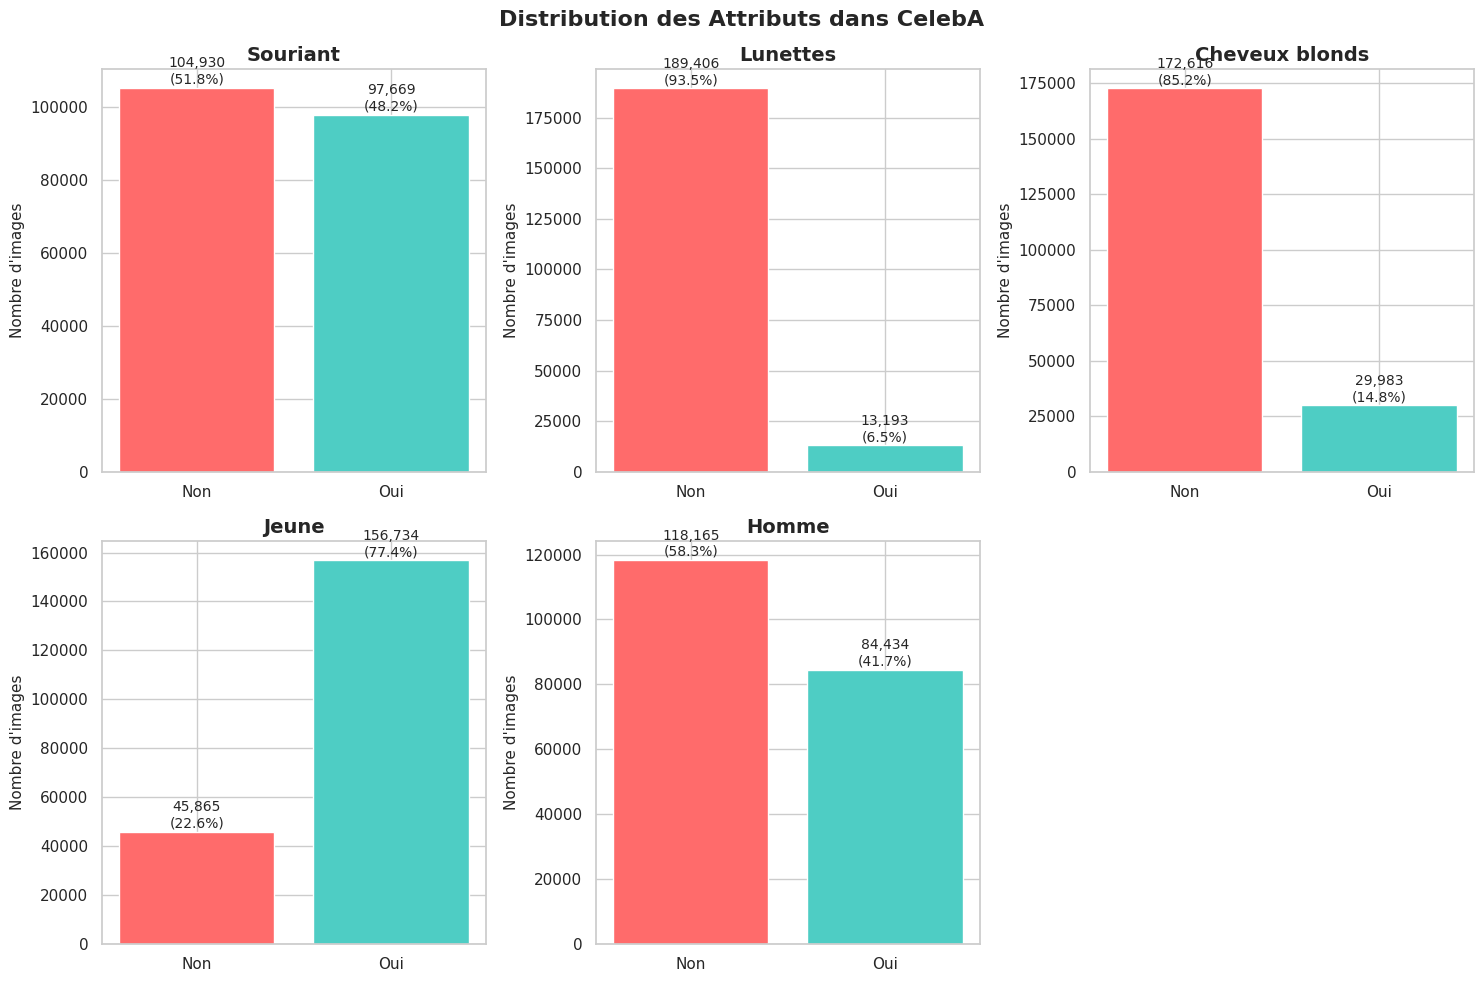


📸 VISUALISATION DES IMAGES


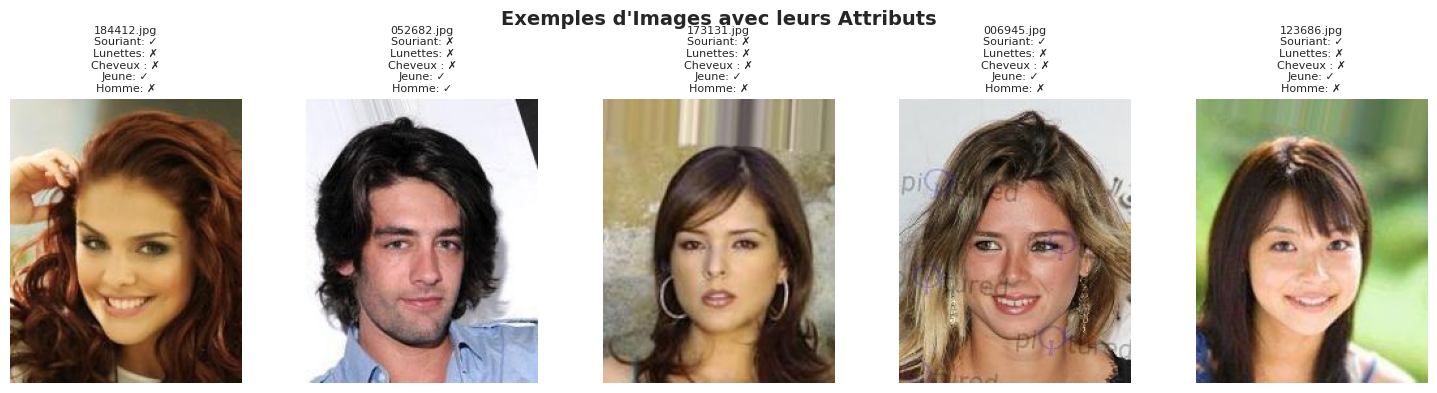


🔗 MATRICE DE CORRÉLATION DES ATTRIBUTS


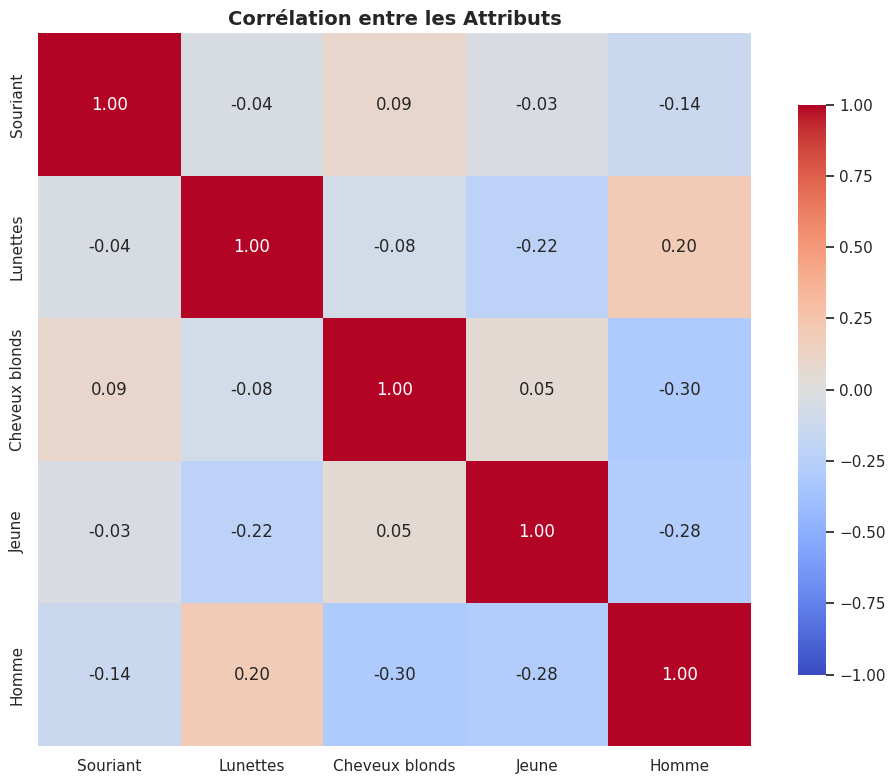


📋 RÉSUMÉ STATISTIQUE
Souriant             (Smiling        ):
  Présence:  97,669 images (  48.2%)
  Absence:  104,930 images (  51.8%)

Lunettes             (Eyeglasses     ):
  Présence:  13,193 images (   6.5%)
  Absence:  189,406 images (  93.5%)

Cheveux blonds       (Blond_Hair     ):
  Présence:  29,983 images (  14.8%)
  Absence:  172,616 images (  85.2%)

Jeune                (Young          ):
  Présence: 156,734 images (  77.4%)
  Absence:   45,865 images (  22.6%)

Homme                (Male           ):
  Présence:  84,434 images (  41.7%)
  Absence:  118,165 images (  58.3%)



In [ ]:
# ## 5. Visualisation des distributions et des images

# %%
# 1. VISUALISATION DES DISTRIBUTIONS
print("📊 DISTRIBUTION DES ATTRIBUTS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, attr in enumerate(SELECTED_ATTRS):
    # Compter les valeurs
    counts = attr_df[attr].value_counts()

    # S'assurer d'avoir 0 et 1
    if 0 not in counts.index:
        counts[0] = 0
    if 1 not in counts.index:
        counts[1] = 0

    # Trier par index
    counts = counts.sort_index()

    # Créer le graphique à barres
    bars = axes[i].bar(['Non', 'Oui'],
                       [counts.get(0, 0), counts.get(1, 0)],
                       color=['#FF6B6B', '#4ECDC4'])

    axes[i].set_title(f'{ATTR_NAMES_FR[i]}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Nombre d\'images', fontsize=11)

    # Ajouter les valeurs
    total = len(attr_df)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / total) * 100
        axes[i].text(bar.get_x() + bar.get_width()/2, height + 500,
                    f'{height:,}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=10)

# Cacher la dernière case si nécessaire
if len(axes) > len(SELECTED_ATTRS):
    axes[-1].axis('off')

plt.suptitle('Distribution des Attributs dans CelebA', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# 2. VISUALISATION DES IMAGES (VERSION SIMPLE)
print("\n📸 VISUALISATION DES IMAGES")
print("=" * 60)

# Trouver des images qui existent
image_files = []
attempts = 0
max_attempts = 20

while len(image_files) < 5 and attempts < max_attempts:
    # Prendre une ligne aléatoire
    sample = attr_df.sample(1)
    img_name = sample.iloc[0]['image_id']

    # Essayer plusieurs formats
    possible_names = [
        img_name,
        f"{int(img_name.split('.')[0]):06d}.jpg",
        img_name.zfill(10),
        img_name.replace('.jpg', '').zfill(6) + '.jpg'
    ]

    for name in possible_names:
        img_path = img_dir / name
        if img_path.exists():
            image_files.append((img_path, sample.iloc[0]))
            break

    attempts += 1

# Afficher les images trouvées
if image_files:
    fig, axes = plt.subplots(1, len(image_files), figsize=(15, 4))
    if len(image_files) == 1:
        axes = [axes]

    for idx, (ax, (img_path, row)) in enumerate(zip(axes, image_files)):
        img = Image.open(img_path)
        ax.imshow(img)

        # Créer le texte des attributs
        attrs_text = []
        for i, attr in enumerate(SELECTED_ATTRS):
            value = '✓' if row[attr] == 1 else '✗'
            color = 'green' if row[attr] == 1 else 'red'
            attrs_text.append(f"{ATTR_NAMES_FR[i][:8]}: {value}")

        ax.set_title(f"{img_path.name}\n" + "\n".join(attrs_text), fontsize=8)
        ax.axis('off')

    plt.suptitle('Exemples d\'Images avec leurs Attributs', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucune image trouvée. Affichage des premières images du dossier...")

    # Afficher les premières images du dossier
    first_images = list(img_dir.glob('*.jpg'))[:5]
    if first_images:
        fig, axes = plt.subplots(1, len(first_images), figsize=(15, 3))
        if len(first_images) == 1:
            axes = [axes]

        for idx, (ax, img_path) in enumerate(zip(axes, first_images)):
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(img_path.name, fontsize=8)
            ax.axis('off')

        plt.suptitle('Premières images du dossier', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image .jpg trouvée dans le dossier")

# %%
# 3. MATRICE DE CORRÉLATION (optionnel)
print("\n🔗 MATRICE DE CORRÉLATION DES ATTRIBUTS")
print("=" * 60)

plt.figure(figsize=(10, 8))
corr_matrix = attr_df[SELECTED_ATTRS].corr()
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt='.2f',
            square=True,
            cbar_kws={"shrink": .8},
            xticklabels=ATTR_NAMES_FR,
            yticklabels=ATTR_NAMES_FR)

plt.title('Corrélation entre les Attributs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# 4. RÉSUMÉ STATISTIQUE
print("\n📋 RÉSUMÉ STATISTIQUE")
print("=" * 60)

for attr, name_fr in zip(SELECTED_ATTRS, ATTR_NAMES_FR):
    positive = attr_df[attr].sum()
    total = len(attr_df)
    percentage = (positive / total) * 100

    print(f"{name_fr:20} ({attr:15}):")
    print(f"  Présence: {positive:>7,} images ({percentage:>6.1f}%)")
    print(f"  Absence:  {(total-positive):>7,} images ({(100-percentage):>6.1f}%)")
    print()

In [ ]:
 ## 6. Préparation des données

# %%
# Division des données
train_df, temp_df = train_test_split(attr_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"📂 Division des données:")
print(f"  - Entraînement: {len(train_df)} images")
print(f"  - Validation: {len(val_df)} images")
print(f"  - Test: {len(test_df)} images")

# Dataset personnalisé PyTorch
class CelebADataset(Dataset):
    """Dataset PyTorch pour CelebA"""

    def __init__(self, dataframe, img_dir, attributes, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.attributes = attributes
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_id']
        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert('RGB')

        labels = torch.FloatTensor(
            [self.dataframe.iloc[idx][attr] for attr in self.attributes]
        )

        if self.transform:
            image = self.transform(image)

        return image, labels

# Transformations
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Création des datasets
train_dataset = CelebADataset(train_df, img_dir, SELECTED_ATTRS, train_transform)
val_dataset = CelebADataset(val_df, img_dir, SELECTED_ATTRS, val_test_transform)
test_dataset = CelebADataset(test_df, img_dir, SELECTED_ATTRS, val_test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ Dataloaders créés avec succès")

📂 Division des données:
  - Entraînement: 141819 images
  - Validation: 30390 images
  - Test: 30390 images
✅ Dataloaders créés avec succès


In [ ]:
 ## 7. Modèle Multi-tâches

# %%
class MultiTaskResNet(nn.Module):
    """Modèle multi-tâches basé sur ResNet50"""

    def __init__(self, num_tasks=5, pretrained=True):
        super(MultiTaskResNet, self).__init__()

        # Backbone ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Geler le backbone initialement
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Couches partagées
        self.shared_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Têtes spécifiques
        self.task_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 1),
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])

        self.num_tasks = num_tasks

    def forward(self, x):
        x = self.backbone(x)
        shared = self.shared_layers(x)
        outputs = [head(shared) for head in self.task_heads]
        return torch.cat(outputs, dim=1)

    def unfreeze_backbone(self, num_layers=10):
        """Dégèle les dernières couches"""
        layers = list(self.backbone.children())
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

# Création du modèle
model = MultiTaskResNet(num_tasks=len(SELECTED_ATTRS), pretrained=True)
model = model.to(device)

print("🏗️ Modèle créé avec succès")
print(f"📊 Paramètres entraînables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


🏗️ Modèle créé avec succès
📊 Paramètres entraînables: 1,378,053


🚀 Début de l'entraînement...

📅 Epoch 1/10


Validation: 100%|██████████| 950/950 [01:50<00:00,  8.56it/s]


📊 Train Loss: 0.3121 | Val Loss: 0.2647

📅 Epoch 2/10


Validation: 100%|██████████| 950/950 [01:49<00:00,  8.64it/s]


📊 Train Loss: 0.2870 | Val Loss: 0.2560

📅 Epoch 3/10


Validation: 100%|██████████| 950/950 [01:49<00:00,  8.71it/s]


📊 Train Loss: 0.2787 | Val Loss: 0.2686

📅 Epoch 4/10


Validation: 100%|██████████| 950/950 [01:48<00:00,  8.76it/s]


📊 Train Loss: 0.2736 | Val Loss: 0.2628

📅 Epoch 5/10


Validation: 100%|██████████| 950/950 [01:48<00:00,  8.75it/s]


📊 Train Loss: 0.2713 | Val Loss: 0.2584

📅 Epoch 6/10


Validation: 100%|██████████| 950/950 [01:49<00:00,  8.67it/s]


📊 Train Loss: 0.2676 | Val Loss: 0.2598

📅 Epoch 7/10


Validation: 100%|██████████| 950/950 [01:48<00:00,  8.75it/s]


📊 Train Loss: 0.2654 | Val Loss: 0.2608

📅 Epoch 8/10


Validation: 100%|██████████| 950/950 [01:49<00:00,  8.71it/s]


📊 Train Loss: 0.2641 | Val Loss: 0.2594

📅 Epoch 9/10


Validation: 100%|██████████| 950/950 [01:49<00:00,  8.67it/s]


📊 Train Loss: 0.2613 | Val Loss: 0.2585

📅 Epoch 10/10


Validation: 100%|██████████| 950/950 [01:48<00:00,  8.72it/s]


📊 Train Loss: 0.2609 | Val Loss: 0.2643

✅ Entraînement terminé!


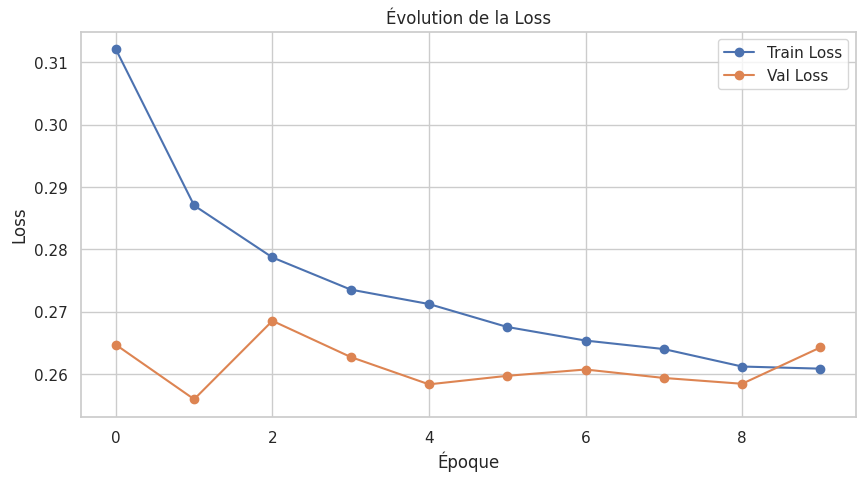

In [ ]:
# ## 8. Entraînement du modèle

# %%
# Configuration
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
NUM_EPOCHS = 10

# Fonctions d'entraînement
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(loader)

# Entraînement
history = {'train_loss': [], 'val_loss': []}

print("🚀 Début de l'entraînement...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Sauvegarde
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

print("\n✅ Entraînement terminé!")

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ## 8.5 - RECONSTRUCTION DU MODÈLE (nécessaire après redémarrage)

# %%
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

# Vérifier le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Redéfinir SELECTED_ATTRS si nécessaire
SELECTED_ATTRS = ['Smiling', 'Eyeglasses', 'Blond_Hair', 'Young', 'Male']
ATTR_NAMES_FR = ['Souriant', 'Lunettes', 'Cheveux blonds', 'Jeune', 'Homme']

# Classe du modèle
class MultiTaskResNet(nn.Module):
    def __init__(self, num_tasks=5, pretrained=True):
        super().__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.shared_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.task_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 1),
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        x = self.backbone(x)
        shared = self.shared_layers(x)
        outputs = [head(shared) for head in self.task_heads]
        return torch.cat(outputs, dim=1)

    def unfreeze_backbone(self, num_layers=10):
        layers = list(self.backbone.children())
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

# Créer le modèle
model = MultiTaskResNet(num_tasks=len(SELECTED_ATTRS), pretrained=True)
model = model.to(device)

print("✅ Modèle créé!")

# %%
# Vérifier les fichiers de modèle existants
import os

print("🔍 Fichiers .pth disponibles:")
model_files = [f for f in os.listdir('.') if f.endswith('.pth')]
for f in sorted(model_files):
    size = os.path.getsize(f) / 1024 / 1024
    print(f"  - {f} ({size:.1f} MB)")

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


✅ Modèle créé!
🔍 Fichiers .pth disponibles:


In [ ]:
# ============================================================================
# FINE-TUNING CLASSIQUE - CELEBA MULTI-TÂCHES (PyTorch)
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# ============================================================================
# 1. FONCTION D'ÉVALUATION COMPLÈTE
# ============================================================================

def evaluate_detailed(model, loader, criterion, device, attr_names):
    """Évaluation avec métriques détaillées par attribut"""
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Évaluation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Métriques par attribut
    metrics = {}
    for i, attr in enumerate(attr_names):
        pred_binary = (all_preds[:, i] >= 0.5).astype(int)
        true_binary = all_labels[:, i].astype(int)

        acc = accuracy_score(true_binary, pred_binary)
        prec, rec, f1, _ = precision_recall_fscore_support(
            true_binary, pred_binary, average='binary', zero_division=0
        )

        try:
            auc = roc_auc_score(true_binary, all_preds[:, i])
        except:
            auc = 0.0

        metrics[attr] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc
        }

    avg_loss = running_loss / len(loader)
    avg_acc = np.mean([m['accuracy'] for m in metrics.values()])

    return avg_loss, avg_acc, metrics

# ============================================================================
# 2. DÉGEL DES DERNIÈRES COUCHES DU BACKBONE
# ============================================================================

def unfreeze_last_n_layers(model, n_layers=30):
    """
    Dégèle les n dernières couches du backbone ResNet50

    Args:
        model: Votre modèle MultiTaskResNet
        n_layers: Nombre de couches à dégeler (défaut: 30)
    """
    # Compter toutes les couches du backbone
    all_layers = []
    for module in model.backbone.modules():
        if len(list(module.children())) == 0:  # Couche feuille
            all_layers.append(module)

    total_layers = len(all_layers)
    print(f"📊 Backbone contient {total_layers} couches au total")

    # Dégeler les n dernières
    layers_to_unfreeze = all_layers[-n_layers:]
    for layer in layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True

    # Afficher le nombre de paramètres entraînables
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ {n_layers} dernières couches dégelées")
    print(f"✅ Paramètres entraînables : {trainable_params:,}")

    return trainable_params

# Alternative: Dégeler par blocs ResNet
def unfreeze_resnet_blocks(model, blocks_to_unfreeze=['layer4']):
    """
    Dégèle des blocs spécifiques de ResNet50

    Args:
        model: Votre modèle MultiTaskResNet
        blocks_to_unfreeze: Liste des blocs à dégeler
                           Options: ['layer1', 'layer2', 'layer3', 'layer4']
    """
    # Le backbone de ResNet50 a cette structure:
    # Sequential(conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool)

    backbone_children = list(model.backbone.children())
    layer_names = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

    trainable_params_before = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for i, (name, layer) in enumerate(zip(layer_names, backbone_children)):
        if name in blocks_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True
            print(f"✅ Bloc '{name}' dégelé")

    trainable_params_after = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Paramètres entraînables : {trainable_params_before:,} → {trainable_params_after:,}")

    return trainable_params_after

# ============================================================================
# 3. FINE-TUNING
# ============================================================================

def fine_tune_model(model, train_loader, val_loader, criterion, device,
                    attr_names, num_epochs=10, learning_rate=1e-5):
    """
    Fine-tuning du modèle avec taux d'apprentissage faible

    Args:
        model: Modèle pré-entraîné
        train_loader, val_loader: DataLoaders
        criterion: Fonction de perte
        device: cuda/cpu
        attr_names: Liste des noms d'attributs
        num_epochs: Nombre d'époques de fine-tuning
        learning_rate: Taux d'apprentissage (très faible pour fine-tuning)
    """

    print("\n" + "=" * 80)
    print("🔥 DÉBUT DU FINE-TUNING")
    print("=" * 80)

    # Optimiseur avec learning rate très faible
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )

    # Scheduler pour réduire encore le LR si nécessaire
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Historique
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_metrics': []
    }

    best_val_loss = float('inf')

    # Boucle d'entraînement
    for epoch in range(num_epochs):
        print(f"\n📅 Époque {epoch+1}/{num_epochs}")

        # === ENTRAÎNEMENT ===
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        with tqdm(train_loader, desc='Training') as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_preds.append(outputs.detach().cpu().numpy())
                train_labels.append(labels.detach().cpu().numpy())

                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Calcul accuracy train
        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        train_acc = np.mean((train_preds >= 0.5) == train_labels)

        # === VALIDATION ===
        val_loss, val_acc, val_metrics = evaluate_detailed(
            model, val_loader, criterion, device, attr_names
        )

        # Scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Historique
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_metrics'].append(val_metrics)

        # Affichage
        print(f"📊 Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
        print(f"📊 Train Acc : {train_acc:.4f} | Val Acc : {val_acc:.4f}")
        print(f"📊 Learning Rate: {current_lr:.2e}")

        # Métriques par attribut
        print("\n📈 Métriques par attribut (Validation):")
        for attr in attr_names:
            m = val_metrics[attr]
            print(f"   {attr:20} | Acc: {m['accuracy']:.3f} | F1: {m['f1']:.3f} | AUC: {m['auc']:.3f}")

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_finetuned.pth')
            print("✅ Meilleur modèle sauvegardé!")

    print("\n" + "=" * 80)
    print("✅ FINE-TUNING TERMINÉ")
    print("=" * 80)

    return history

# ============================================================================
# 4. VISUALISATION DES RÉSULTATS
# ============================================================================

def plot_finetuning_results(history, attr_names):
    """Visualise les résultats du fine-tuning"""

    fig = plt.figure(figsize=(20, 10))

    # 1. Loss
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    plt.plot(history['val_loss'], label='Val Loss', marker='o', linewidth=2)
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Évolution de la Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # 2. Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    plt.plot(history['val_acc'], label='Val Acc', marker='o', linewidth=2)
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # 3. Accuracy finale par attribut
    plt.subplot(2, 3, 3)
    last_metrics = history['val_metrics'][-1]
    accs = [last_metrics[attr]['accuracy'] for attr in attr_names]
    colors = ['#2ecc71' if acc > 0.90 else '#f39c12' if acc > 0.80 else '#e74c3c' for acc in accs]
    bars = plt.barh(attr_names, accs, color=colors)
    plt.xlabel('Accuracy', fontsize=12)
    plt.title('Accuracy par Attribut (Finale)', fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3, axis='x')
    for i, (bar, acc) in enumerate(zip(bars, accs)):
        plt.text(acc + 0.02, i, f'{acc:.3f}', va='center', fontsize=10)

    # 4. F1-Score par attribut
    plt.subplot(2, 3, 4)
    f1s = [last_metrics[attr]['f1'] for attr in attr_names]
    colors = ['#2ecc71' if f1 > 0.85 else '#f39c12' if f1 > 0.75 else '#e74c3c' for f1 in f1s]
    bars = plt.barh(attr_names, f1s, color=colors)
    plt.xlabel('F1-Score', fontsize=12)
    plt.title('F1-Score par Attribut (Finale)', fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3, axis='x')
    for i, (bar, f1) in enumerate(zip(bars, f1s)):
        plt.text(f1 + 0.02, i, f'{f1:.3f}', va='center', fontsize=10)

    # 5. AUC par attribut
    plt.subplot(2, 3, 5)
    aucs = [last_metrics[attr]['auc'] for attr in attr_names]
    colors = ['#2ecc71' if auc > 0.90 else '#f39c12' if auc > 0.80 else '#e74c3c' for auc in aucs]
    bars = plt.barh(attr_names, aucs, color=colors)
    plt.xlabel('AUC', fontsize=12)
    plt.title('AUC par Attribut (Finale)', fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3, axis='x')
    for i, (bar, auc) in enumerate(zip(bars, aucs)):
        plt.text(auc + 0.02, i, f'{auc:.3f}', va='center', fontsize=10)

    # 6. Évolution de l'accuracy par attribut
    plt.subplot(2, 3, 6)
    for attr in attr_names:
        acc_evolution = [metrics[attr]['accuracy'] for metrics in history['val_metrics']]
        plt.plot(acc_evolution, label=attr, marker='o', linewidth=2)
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Évolution par Attribut', fontsize=14, fontweight='bold')
    plt.legend(fontsize=9, loc='best')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('finetuning_results.png', dpi=300, bbox_inches='tight')
    print("✅ Graphiques sauvegardés : finetuning_results.png")
    plt.show()

# ============================================================================
# 5. SCRIPT PRINCIPAL DE FINE-TUNING
# ============================================================================

def main_finetuning():
    """
    Script principal pour le fine-tuning

    PRÉREQUIS:
    - Modèle déjà entraîné (avec backbone gelé)
    - model, train_loader, val_loader, test_loader définis
    - criterion, device, SELECTED_ATTRS définis
    """

    print("\n" + "=" * 80)
    print("🔥 CONFIGURATION DU FINE-TUNING")
    print("=" * 80)

    # Charger le meilleur modèle pré-entraîné
    print("\n📂 Chargement du modèle pré-entraîné...")
    model.load_state_dict(torch.load('best_model.pth'))
    print("✅ Modèle chargé")

    # OPTION 1: Dégeler les 30 dernières couches
    print("\n🔓 Dégel des dernières couches du backbone...")
    unfreeze_last_n_layers(model, n_layers=30)

    # OPTION 2 (Alternative): Dégeler les 2 derniers blocs ResNet
    # print("\n🔓 Dégel des blocs layer3 et layer4...")
    # unfreeze_resnet_blocks(model, blocks_to_unfreeze=['layer3', 'layer4'])

    # Configuration du fine-tuning
    NUM_EPOCHS_FT = 10
    LEARNING_RATE_FT = 1e-5  # Très faible pour fine-tuning

    print(f"\n⚙️ Paramètres de fine-tuning:")
    print(f"   Époques       : {NUM_EPOCHS_FT}")
    print(f"   Learning Rate : {LEARNING_RATE_FT:.2e}")

    # Lancer le fine-tuning
    history_ft = fine_tune_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        attr_names=SELECTED_ATTRS,
        num_epochs=NUM_EPOCHS_FT,
        learning_rate=LEARNING_RATE_FT
    )

    # Visualisation
    print("\n📊 Génération des visualisations...")
    plot_finetuning_results(history_ft, SELECTED_ATTRS)

    # Évaluation finale sur test set
    print("\n📊 Évaluation finale sur le test set...")
    model.load_state_dict(torch.load('best_model_finetuned.pth'))
    test_loss, test_acc, test_metrics = evaluate_detailed(
        model, test_loader, criterion, device, SELECTED_ATTRS
    )

    print(f"\n🎯 RÉSULTATS FINAUX (TEST SET):")
    print(f"   Loss    : {test_loss:.4f}")
    print(f"   Accuracy: {test_acc:.4f}")
    print("\n📈 Détails par attribut:")
    for attr in SELECTED_ATTRS:
        m = test_metrics[attr]
        print(f"   {attr:20} | Acc: {m['accuracy']:.3f} | Prec: {m['precision']:.3f} | Rec: {m['recall']:.3f} | F1: {m['f1']:.3f} | AUC: {m['auc']:.3f}")

    return history_ft, test_metrics

# ============================================================================
# EXÉCUTION
# ============================================================================

if __name__ == "__main__":
    """
    Pour exécuter le fine-tuning, assurez-vous d'avoir:

    1. Entraîné le modèle initial (backbone gelé)
    2. Défini les variables suivantes dans votre notebook:
       - model (votre MultiTaskResNet)
       - train_loader, val_loader, test_loader
       - criterion (nn.BCELoss())
       - device
       - SELECTED_ATTRS (liste des noms d'attributs)

    Puis exécutez:
    >>> history_ft, test_metrics = main_finetuning()
    """

    # Exemple d'utilisation
    print("📝 Pour lancer le fine-tuning, exécutez dans votre notebook:")
    print(">>> history_ft, test_metrics = main_finetuning()")

    # Ou exécutez directement si toutes les variables sont définies
    # history_ft, test_metrics = main_finetuning()

📝 Pour lancer le fine-tuning, exécutez dans votre notebook:
>>> history_ft, test_metrics = main_finetuning()
